<a href="https://colab.research.google.com/github/Vaishnavi-mocherla/song-popularity-prediction/blob/main/models/Copy_of_final_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

### Loading the modified dataset


In [7]:

df = pd.read_csv('merged_101.csv')
df.columns


Index(['id', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'liveness', 'loudness', 'popularity',
       'speechiness', 'tempo', 'valence', 'year', 'key_0', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'minor', 'major', 'acousticness_ar', 'danceability_ar',
       'duration_ms_ar', 'energy_ar', 'instrumentalness_ar', 'liveness_ar',
       'loudness_ar', 'speechiness_ar', 'tempo_ar', 'valence_ar',
       'popularity_ar', 'count', 'key_0_ar', 'key_1_ar', 'key_2_ar',
       'key_3_ar', 'key_4_ar', 'key_5_ar', 'key_6_ar', 'key_7_ar', 'key_8_ar',
       'key_9_ar', 'key_10_ar', 'key_11_ar', 'minor_ar', 'major_ar',
       'acousticness_yr', 'danceability_yr', 'duration_ms_yr', 'energy_yr',
       'instrumentalness_yr', 'liveness_yr', 'loudness_yr', 'speechiness_yr',
       'tempo_yr', 'valence_yr', 'popularity_yr', 'mode', 'key_0_yr',
       'key_1_yr', 'key_2_yr', 'key_3_yr

In [8]:

df.shape


(172230, 73)

In [9]:

del df['mode']  ## Deleted unnecessary attributes
del df['key_6_yr']
del df['loudness']
del df['id']


In [10]:

## Dropping the "popularity" attribute from the data frame and declaring it as the dependent variable or the output
X = df[df.columns.difference(['popularity'])]
y = pd.cut(x=df["popularity"], bins=[-1,42,100], labels=[0,1])

### Standardizing the data and splitting it into training and testing sets


In [11]:

input_scaler = StandardScaler()
X_normalized = input_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.30, random_state=42, stratify=y
)


In [13]:

### Defining the models with pre-defined hyperparameters

tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=2)
log_clf = LogisticRegression(C=0.012742749857031334, penalty='l1', solver='saga')
#ada_clf = AdaBoostClassifier(base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200)
ada_base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
ada_clf = AdaBoostClassifier(base_estimator=ada_base_estimator, learning_rate=0.1, n_estimators=200)
ppn_clf = Perceptron(eta0=0.01, max_iter=10000)
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, objective='binary:logistic')


In [14]:

### Creating pipelines for each model

tree_pipe = Pipeline([('tree_clf', tree_clf)])
log_pipe = Pipeline([('log_clf', log_clf)])
ada_pipe = Pipeline([('ada_clf', ada_clf)])
ppn_pipe = Pipeline([('ppn_clf', ppn_clf)])
xgb_pipe = Pipeline([('xgb_clf', xgb_clf)])


In [15]:

### Defining the Voting Classifier

vote_clf = VotingClassifier(estimators=[('tree_pipe', tree_pipe), ('log_pipe', log_pipe), ('ppn_pipe', ppn_pipe), ('ada_pipe', ada_pipe), ('xgb_pipe', xgb_pipe)],
                         voting='hard', n_jobs=-1)

### Training the final Voting Classifier


In [16]:

vote_clf.fit(X_train, y_train)

### Making predictions and evaluating the final model


VotingClassifier(estimators=[('tree_pipe',
                              Pipeline(steps=[('tree_clf',
                                               DecisionTreeClassifier(max_depth=10,
                                                                      min_samples_leaf=4))])),
                             ('log_pipe',
                              Pipeline(steps=[('log_clf',
                                               LogisticRegression(C=0.012742749857031334,
                                                                  penalty='l1',
                                                                  solver='saga'))])),
                             ('ppn_pipe',
                              Pipeline(steps=[('ppn_clf',
                                               Perceptron(eta0=0.01,
                                                          max_iter=10000))])),
                             ('ada_pipe',
                              Pipeline(steps=...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=7,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))],
                 n_jobs=-1)

In [17]:

y_pred = vote_clf.predict(X_test)

In [18]:

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.8910565329307709
Confusion Matrix:
 [[37230  1581]
 [ 4048  8810]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     38811
           1       0.85      0.69      0.76     12858

    accuracy                           0.89     51669
   macro avg       0.87      0.82      0.84     51669
weighted avg       0.89      0.89      0.89     51669



In [19]:
from sklearn.metrics import roc_curve, auc

In [20]:
# Calculating ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

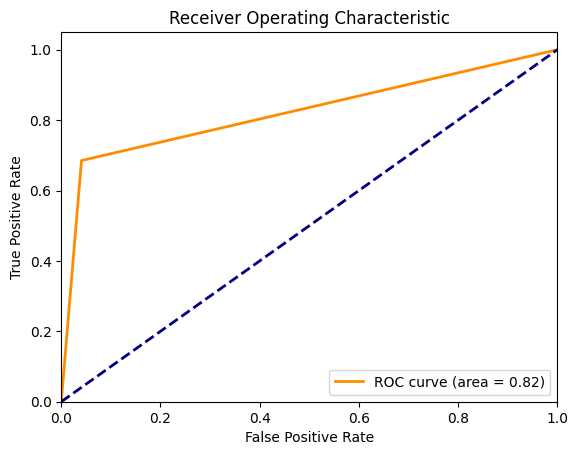

In [21]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
df

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,popularity,speechiness,tempo,...,speechiness_yr,tempo_yr,valence_yr,popularity_yr,key_0_yr,key_1_yr,key_2_yr,key_3_yr,key_4_yr,key_5_yr
0,0.013100,0.2560,182347,0.895,0,0.000106,0.0821,29,0.0707,191.307,...,0.064961,120.209319,0.583424,35.272231,0,0,1,0,0,0
1,0.980000,0.2770,206972,0.145,0,0.879000,0.1110,0,0.0845,75.644,...,0.092591,110.008113,0.432251,3.672500,1,0,0,0,0,0
2,0.795000,0.6850,314667,0.483,0,0.878000,0.1130,1,0.0337,97.694,...,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
3,0.656000,0.7880,179747,0.808,0,0.000000,0.1540,0,0.0395,113.046,...,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
4,0.302000,0.0753,498560,0.150,0,0.884000,0.1210,0,0.0371,76.558,...,0.107351,109.569882,0.443625,3.419500,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172225,0.000067,0.5670,37000,0.862,0,0.875000,0.4810,0,0.0670,102.828,...,0.121045,123.644288,0.426566,27.599484,0,0,0,0,1,0
172226,0.000994,0.3960,501824,0.979,0,0.609000,0.1360,0,0.0878,161.461,...,0.097627,124.621497,0.438681,29.107904,1,0,0,0,0,0
172227,0.864000,0.6380,161560,0.156,0,0.000000,0.1830,20,0.0741,103.905,...,0.057619,112.511724,0.490335,19.231500,1,0,0,0,0,0
172228,0.029900,0.5330,342827,0.547,0,0.011300,0.0723,35,0.0326,72.506,...,0.053659,119.346342,0.593672,33.923039,0,0,1,0,0,0


In [23]:
pd.set_option('display.max_columns', None)


In [25]:
df.head() # Display the first 5 rows


,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,popularity,speechiness,tempo,valence,year,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,minor,major,acousticness_ar,danceability_ar,duration_ms_ar,energy_ar,instrumentalness_ar,liveness_ar,loudness_ar,speechiness_ar,tempo_ar,valence_ar,popularity_ar,count,key_0_ar,key_1_ar,key_2_ar,key_3_ar,key_4_ar,key_5_ar,key_6_ar,key_7_ar,key_8_ar,key_9_ar,key_10_ar,key_11_ar,minor_ar,major_ar,acousticness_yr,danceability_yr,duration_ms_yr,energy_yr,instrumentalness_yr,liveness_yr,loudness_yr,speechiness_yr,tempo_yr,valence_yr,popularity_yr,key_0_yr,key_1_yr,key_2_yr,key_3_yr,key_4_yr,key_5_yr
0,0.0131,0.2560,182347,0.895,0,0.000106,0.0821,29,0.0707,191.307,0.5550,1978,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.145175,0.523720,221014.800000,0.726840,0.023547,0.174298,-7.711613,0.045116,132.180853,0.701493,36.833333,150.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.341064,0.538997,247988.145057,0.552657,0.103383,0.217524,-11.095111,0.064961,120.209319,0.583424,35.272231,0,0,1,0,0,0
1,0.9800,0.2770,206972,0.145,0,0.879000,0.1110,0,0.0845,75.644,0.4940,1953,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.962233,0.464711,199313.805031,0.217114,0.549370,0.166036,-14.844384,0.071003,102.967642,0.539736,2.974843,159.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.891747,0.440834,216552.259500,0.267418,0.314625,0.221442,-15.414304,0.092591,110.008113,0.432251,3.672500,1,0,0,0,0,0
2,0.7950,0.6850,314667,0.483,0,0.878000,0.1130,1,0.0337,97.694,0.8540,1954,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.866200,0.630400,291778.600000,0.567800,0.895600,0.114200,-10.003400,0.040800,117.398600,0.837800,6.800000,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.867413,0.460371,225951.758500,0.263561,0.291320,0.216008,-15.342991,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
3,0.6560,0.7880,179747,0.808,0,0.000000,0.1540,0,0.0395,113.046,0.9690,1954,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.721667,0.739333,175231.000000,0.745000,0.000001,0.077933,-4.730333,0.138767,127.433000,0.929667,2.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.867413,0.460371,225951.758500,0.263561,0.291320,0.216008,-15.342991,0.103243,108.561912,0.447291,7.707000,0,0,0,1,0,0
4,0.3020,0.0753,498560,0.150,0,0.884000,0.1210,0,0.0371,76.558,0.0351,1951,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.817780,0.196522,521790.596429,0.309415,0.665675,0.246221,-15.794201,0.041948,94.257485,0.111619,1.666667,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.900334,0.461423,212773.310500,0.257270,0.303290,0.219540,-15.724956,0.107351,109.569882,0.443625,3.419500,1,0,0,0,0,0


In [26]:
X.head()

,acousticness,acousticness_ar,acousticness_yr,count,danceability,danceability_ar,danceability_yr,duration_ms,duration_ms_ar,duration_ms_yr,energy,energy_ar,energy_yr,explicit,instrumentalness,instrumentalness_ar,instrumentalness_yr,key_0,key_0_ar,key_0_yr,key_1,key_10,key_10_ar,key_11,key_11_ar,key_1_ar,key_1_yr,key_2,key_2_ar,key_2_yr,key_3,key_3_ar,key_3_yr,key_4,key_4_ar,key_4_yr,key_5,key_5_ar,key_5_yr,key_6,key_6_ar,key_7,key_7_ar,key_8,key_8_ar,key_9,key_9_ar,liveness,liveness_ar,liveness_yr,loudness_ar,loudness_yr,major,major_ar,minor,minor_ar,popularity_ar,popularity_yr,speechiness,speechiness_ar,speechiness_yr,tempo,tempo_ar,tempo_yr,valence,valence_ar,valence_yr,year
0,0.0131,0.145175,0.341064,150.0,0.2560,0.523720,0.538997,182347,221014.800000,247988.145057,0.895,0.726840,0.552657,0,0.000106,0.023547,0.103383,0,0.0,0,0,0,0.0,0,0.0,0.0,0,1,1.0,1,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.0821,0.174298,0.217524,-7.711613,-11.095111,1,1.0,0,0.0,36.833333,35.272231,0.0707,0.045116,0.064961,191.307,132.180853,120.209319,0.5550,0.701493,0.583424,1978
1,0.9800,0.962233,0.891747,159.0,0.2770,0.464711,0.440834,206972,199313.805031,216552.259500,0.145,0.217114,0.267418,0,0.879000,0.549370,0.314625,0,0.0,1,0,0,0.0,0,0.0,1.0,0,0,0.0,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.1110,0.166036,0.221442,-14.844384,-15.414304,1,1.0,0,0.0,2.974843,3.672500,0.0845,0.071003,0.092591,75.644,102.967642,110.008113,0.4940,0.539736,0.432251,1953
2,0.7950,0.866200,0.867413,10.0,0.6850,0.630400,0.460371,314667,291778.600000,225951.758500,0.483,0.567800,0.263561,0,0.878000,0.895600,0.291320,0,1.0,0,0,0,0.0,0,0.0,0.0,0,1,0.0,0,0,0.0,1,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.1130,0.114200,0.216008,-10.003400,-15.342991,0,1.0,1,0.0,6.800000,7.707000,0.0337,0.040800,0.103243,97.694,117.398600,108.561912,0.8540,0.837800,0.447291,1954
3,0.6560,0.721667,0.867413,6.0,0.7880,0.739333,0.460371,179747,175231.000000,225951.758500,0.808,0.745000,0.263561,0,0.000000,0.000001,0.291320,0,0.0,0,0,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0.0,1,0,0.0,0,1,1.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0.1540,0.077933,0.216008,-4.730333,-15.342991,1,0.0,0,1.0,2.000000,7.707000,0.0395,0.138767,0.103243,113.046,127.433000,108.561912,0.9690,0.929667,0.447291,1954
4,0.3020,0.817780,0.900334,280.0,0.0753,0.196522,0.461423,498560,521790.596429,212773.310500,0.150,0.309415,0.257270,0,0.884000,0.665675,0.303290,0,0.0,1,0,0,0.0,0,0.0,0.0,0,1,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,1.0,0,0.0,0,0.0,0.1210,0.246221,0.219540,-15.794201,-15.724956,0,1.0,1,1.0,1.666667,3.419500,0.0371,0.041948,0.107351,76.558,94.257485,109.569882,0.0351,0.111619,0.443625,1951


In [40]:
import pickle


In [47]:

# Save the model in a pickle file
with open('voting_classifier.pkl', 'wb') as f:
    pickle.dump(vote_clf, f)


In [48]:

# Load the saved model
with open('voting_classifier.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [69]:
#new_data = [[ 0.9800, 0.962233, 0.891747, 159.0, 0.2770, 0.464711, 0.440834, 206972, 199313.805031, 216552.259500, 0.145, 0.217114, 0.267418, 0, 0.879000, 0.549370, 0.314625, 0, 0.0, 1, 0, 0, 0.0, 0, 0.0, 1.0, 0, 0, 0.0, 0, 1, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0.1110, 0.166036, 0.221442, -14.844384, -15.414304, 1, 1.0, 0, 0.0, 2.974843, 3.672500, 0.0845, 0.071003, 0.092591, 75.644, 102.967642, 110.008113, 0.4940, 0.539736, 0.432251, 1953 ]]
#new_data = [[ 0.0131, 0.145175, 0.341064, 150.0, 0.2560, 0.523720, 0.538997, 182347, 221014.800000, 247988.145057, 0.895, 0.726840, 0.552657, 0, 0.000106, 0.023547, 0.103383, 0, 0.0, 0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 1, 1.0, 1, 0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0.0821, 0.174298, 0.217524, -7.711613, -11.095111, 1, 1.0, 0, 0.0, 36.833333, 35.272231, 0.0707, 0.045116, 0.064961, 191.307, 132.180853, 120.209319, 0.5550, 0.701493, 0.583424, 1978 ]]
new_data = [[ 0.6560, 0.721667, 0.867413, 6.0, 0.7880, 0.739333, 0.460371, 179747, 175231.000000, 225951.758500, 0.808, 0.745000, 0.263561, 0, 0.000000, 0.000001, 0.291320, 0, 0.0, 0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0, 0, 0.0, 1, 0, 0.0, 0, 1, 1.0, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0, 0.0, 0.1540, 0.077933, 0.216008, -4.730333, -15.342991, 1, 0.0, 0, 1.0, 0.000000, 7.707000, 0.9395, 0.938767, 0.903243, 113.046, 127.433000, 108.561912, 0.9690, 0.929667, 0.447291, 1954 ]]


In [70]:
len(new_data[0])

68

In [71]:

# Make a prediction on the new data point
prediction = loaded_model.predict(new_data)


In [72]:
print("Prediction:", prediction)


Prediction: [0]
